# Train

> In this module, we develop trainers of different models

In [2]:
#| default_exp train

In [3]:
#| hide
import sys
sys.path.append("/notebooks/tools")
from tools.dataset import Data
from tools.feature import *

In [4]:
#| hide
from nbdev.showdoc import *
%matplotlib inline

In [ ]:
#| export
from fastbook import *

In [140]:
#| export
def xgb_trainer(df,
                feature_col,
                target_col,
                test_index=None,
                xgb_params = { 
                            'max_depth':7, #from 4 to 7
                            'learning_rate':0.001, #from 0.001
                            'subsample':0.8,
                            'colsample_bytree':0.2, # from 0.2 to 1, because need to take position
                            'eval_metric':'rmse',
                            'objective':'reg:squarederror',
                            'tree_method':'gpu_hist',
                            'predictor':'gpu_predictor',
                            'random_state':123
                        }
               ):
    
    X = df[feature_col]
    y = df[target_col]
    
    print(f'xgb params is: {xgb_params}')
    
    if test_index is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    else:
        X_train,y_train = X.loc[~X.index.isin(test_index)],y.loc[~X.index.isin(test_index)]
        X_test, y_test = X.loc[test_index],y.loc[test_index]

        
    print(X_train.shape,y_train.shape,X_test.shape, y_test.shape)
    print(y_test.index)
    #prepare matrix for xgb
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    
    model = xgb.train(xgb_params, 
            dtrain=dtrain,
            evals=[(dtrain,'train'),(dtest,'valid')],
            num_boost_round=9999,
            early_stopping_rounds=100,
            verbose_eval=100,)
    
    pred = model.predict(dtest)
    spearman_corr, _ = spearmanr(y_test, pred)
    print(f'Spearman correlation: {spearman_corr:.2f}')
    
    fig, ax = plt.subplots()
    ax.scatter(y_test, pred)
    ax.set_xlabel('True values')
    ax.set_ylabel('Predicted values')
    ax.set_title('Scatter plot of true versus predicted values')
    plt.show()
    plt.close()
    
    
    dd = model.get_score(importance_type='gain')
    gain = pd.DataFrame({'feature':dd.keys(),f'gain_importance':dd.values()})
    gain.set_index('feature').sort_values(by = 'gain_importance')[:15].plot.barh(figsize=(10,20))
    plt.show()
    plt.close()
    
        
    dd = model.get_score(importance_type='weight')
    weight = pd.DataFrame({'feature':dd.keys(),f'weight_importance':dd.values()})
    weight.set_index('feature').sort_values(by = 'weight_importance')[:15].plot.barh(figsize=(10,20))
    plt.show()
    plt.close()
    
    return gain, weight

In [102]:
show_doc(xgb_trainer)

---

### xgb_trainer

>      xgb_trainer (df, feature_col, target_col, test_index=None,
>                   xgb_params={'max_depth': 7, 'learning_rate': 0.001,
>                   'subsample': 0.8, 'colsample_bytree': 0.2, 'eval_metric':
>                   'rmse', 'objective': 'reg:squarederror', 'tree_method':
>                   'gpu_hist', 'predictor': 'gpu_predictor', 'random_state':
>                   123})

In [105]:
df = Data.get_g12d()

In [106]:
df

,ID,SMILES,group,with_3F,racemic_trans,mixture_isomer,trans,Kd,IC50,erk_IC50
0,US_1,CN1CCC[C@H]1COc1nc(N2CC3CCC(C2)N3)c2cnc(cc2n1)-c1cc(O)cc2ccccc12,US,0,0,0,0,97.7,124.7,3159.1
1,US_2,CN1CCC[C@H]1COc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2n1)-c1cc(O)cc2ccccc12,US,1,0,0,0,2.4,2.7,721.4
2,US_3,Cn1ccnc1CCOc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2n1)-c1cc(O)cc2ccccc12,US,0,0,0,0,8.3,9.5,10283.1
3,US_4,Oc1cc(-c2ncc3c(nc(OCCc4ccccn4)nc3c2F)N2CC3CCC(C2)N3)c2ccccc2c1,US,0,0,0,0,155.7,496.2,8530.0
4,US_5,Cn1nccc1COc1nc(N2CC3CCC(C2)N3)c2cnc(c(F)c2n1)-c1cc(O)cc2ccccc12,US,0,0,0,0,294.8,722.9,8193.8
...,...,...,...,...,...,...,...,...,...,...
717,paper_34,FC1=C(C2=C(C=C(F)C=C3)C3=CC=C2)N=CC4=C1N=C(OCC56N(CCC6)CCC5)N=C4N7C[C@@H](CC8)N[C@@H]8C7,paper,0,0,0,0,NaN,27.0,370.0
718,paper_35,FC1=C(C2=C(C(F)=C(F)C=C3)C3=CC=C2)N=CC4=C1N=C(OCC56N(CCC6)CCC5)N=C4N7C[C@@H](CC8)N[C@@H]8C7,paper,0,0,0,0,NaN,7.0,97.0
719,paper_36,FC1=C(C2=C(C(C#C)=C(F)C=C3)C3=CC=C2)N=CC4=C1N=C(OCC56N(CCC6)CCC5)N=C4N7C[C@@H](CC8)N[C@@H]8C7,paper,0,0,0,0,NaN,2.0,24.0
720,paper_37,FC1=C(C2=C(C(Cl)=CC=C3)C3=CC(O)=C2)N=CC4=C1N=C(OCC56N(CCC6)CCC5)N=C4N7C[C@@H](CC8)N[C@@H]8C7,paper,0,0,0,0,NaN,2.0,63.0


Prepare training df

In [7]:
smi_feat = smi2prop(df,'SMILES','ID',True,True)

In [8]:
smi_feat

,ID,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ether,fr_guanido,fr_halogen,fr_imidazole,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_para_hydroxylation,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_unbrch_alkane,fr_urea
0,US_1,-1.932028,0.932171,1.381110,0.495241,-1.183587,-1.219109,-1.182076,-1.046640,-0.203173,-1.070885,0.960805,-0.201299,-0.606818,-0.027786,0.238330,-0.929849,0.169612,-1.291745,0.519884,-1.519547,0.185658,-0.425142,0.608875,0.337035,-0.603426,-1.036679,-0.801448,-0.917005,-0.932184,-0.777188,-0.867430,-0.807099,-0.902348,-0.806015,-0.900582,-0.864011,-0.972370,-0.126939,-0.154995,-1.075533,-0.754664,-0.327962,-0.976340,0.813537,-1.109378,-1.722754,-0.237511,-0.150438,-0.258243,-0.690788,-1.677478,-0.252705,-0.275917,-0.455194,0.586341,-0.695775,0.424056,-0.818465,-0.302768,-0.193272,0.123156,-0.361079,-0.742411,-0.199686,-0.279138,0.655344,-0.36044,-1.709988,0.908283,-0.727266,0.045041,-0.772241,-1.454431,-0.791409,0.740918,-0.673271,0.606634,0.257682,-1.120582,-0.123426,-1.959448,-1.622800,-1.137956,0.581413,0.436907,-0.082673,0.600444,-0.316618,0.410895,-1.477411,-0.713491,-0.020944,0.966588,0.316115,0.706608,1.074237,0.035838,-0.307140,0.688654,-0.495195,-0.975006,0.504157,0.034921,-0.393,-0.446513,-0.613431,0.241193,0.123187,0.298974,0.164340,0.642889,-1.190554,-0.645101,-0.356435,-0.308046,-0.465984,-0.535647,-0.875193,-0.643206,-0.037242,-0.289541,-0.278433,-0.145659,-0.016211,-0.164399,1.260085,-0.052705,-0.321026,-0.31841,-0.087167,-0.037242,-0.098784,-0.261324,-0.215353,-0.051678,1.432247,1.722508,-0.091542,-0.14062,-0.508104,-0.070507,-0.309352,-0.493979,-0.51257,-0.342359,-0.052705,-0.316228,-0.052705,-1.583939,-0.204565,-0.037242,-0.258067,-0.145659,-0.185429,-0.211808,-0.183176,0.327661,-0.052705,0.357590,-0.037242,-0.083507,-0.037242,-0.052705,-0.204565,-0.091542,-0.16413,-0.037242
1,US_2,0.370290,0.282627,-0.324387,0.318811,-0.840874,-0.837744,-0.838700,-0.740120,-0.200922,-1.070885,0.960805,-0.198749,0.203344,0.332533,0.322539,-0.646890,0.160857,-1.217596,0.513626,-0.927388,0.182332,-0.416530,0.608299,0.705937,-0.323952,-0.697765,-0.663958,-0.781950,-0.685520,-0.697979,-0.791224,-0.730912,-0.830814,-0.734399,-0.831915,-0.806103,-0.915471,-0.260409,-0.153546,-0.753847,-0.57500

In [108]:
df = df.merge(smi_feat)

In [110]:
df = df.dropna(subset = ['IC50'])
df = df.query('IC50<2000').reset_index(drop=True)

In [111]:
df.shape

(603, 177)

In [115]:
FEATURES = smi_feat.columns[1:]

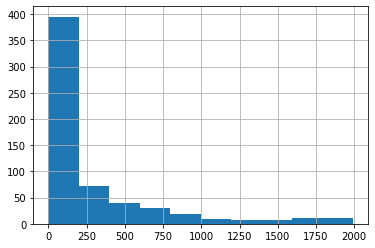

In [116]:
df['IC50'].hist();

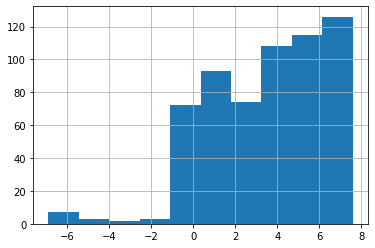

In [117]:
# train['IC50'].apply(lambda x: np.log(x)).hist();

In [131]:
df['pIC50'] = df['IC50'].apply(lambda x: -np.log(x))

In [120]:
df.group.unique()

array(['US', '31678', '646', '625', 'paper'], dtype=object)

In [129]:
df.query('group == "31678"').index

Int64Index([399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
            412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
            425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
            438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
            451, 452],
           dtype='int64')

In [ ]:
# seq = Data.get_kseq()

# seq_feat = esm_embeddings(seq,"g12d_seq")

# seq

# seq_feat = seq_feat.rename(lambda x: f"esm_{x}",axis=1)

# seq_feat

# seq_feat = seq_feat.drop(1)

# import pandas as pd

# seq_feat = pd.concat([seq_feat]*722, ignore_index=True)

# train = pd.concat([smi_feat,seq_feat],axis=1)

# df

# train['IC50'] = df.IC50

# train = train.drop(['ID'],axis=1)

## Train

In [132]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

In [144]:
df.IC50.sort_values()

391       0.001
397       0.002
393       0.002
394       0.002
398       0.002
         ...   
343    1946.500
77     1949.700
293    1980.600
111    1981.100
140    1990.600
Name: IC50, Length: 603, dtype: float64

In [146]:
df.pIC50.sort_values()

140   -7.596191
111   -7.591408
293   -7.591155
77    -7.575431
343   -7.573788
         ...   
395    6.214608
396    6.214608
397    6.214608
394    6.214608
391    6.907755
Name: pIC50, Length: 603, dtype: float64

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 0.2, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(482, 167) (482, 1) (121, 167) (121, 1)
Int64Index([314,  43, 102, 475, 363, 368, 598, 505, 417, 565,
            ...
            523, 580, 217, 415, 171, 352, 303, 445,  34, 328],
           dtype='int64', length=121)
[0]	train-rmse:4.93098	valid-rmse:4.62673
[100]	train-rmse:4.53070	valid-rmse:4.28077
[200]	train-rmse:4.16815	valid-rmse:3.97412
[300]	train-rmse:3.84026	valid-rmse:3.70174
[400]	train-rmse:3.54312	valid-rmse:3.45979
[500]	train-rmse:3.27464	valid-rmse:3.24718
[600]	train-rmse:3.03174	valid-rmse:3.06188
[700]	train-rmse:2.81161	valid-rmse:2.89966
[800]	train-rmse:2.61308	valid-rmse:2.75734
[900]	train-rmse:2.43437	valid-rmse:2.63623
[1000]	train-rmse:2.27203	valid-rmse:2.53076
[1100]	train-rmse:2.12497	valid-rmse:2.43877
[1200]	train-rmse:1.

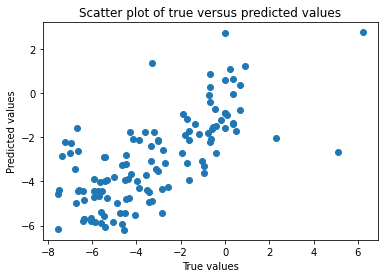

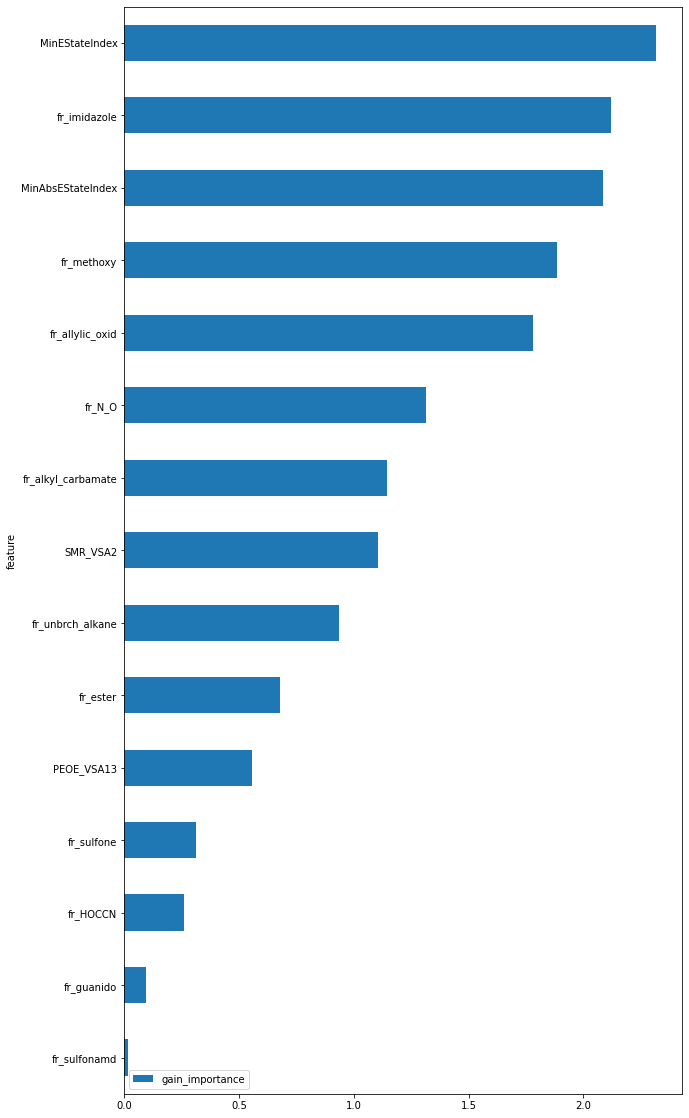

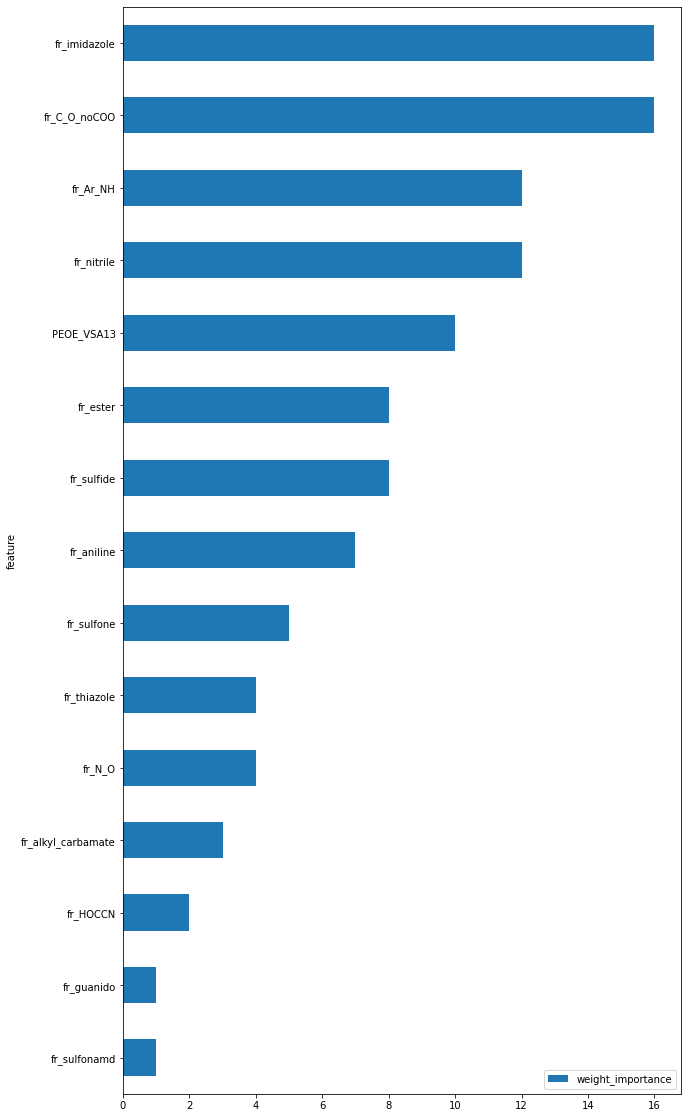

(               feature  gain_importance
 0       MaxEStateIndex         2.479035
 1       MinEStateIndex         2.315347
 2    MinAbsEStateIndex         2.086583
 3                  qed         2.660203
 4                MolWt         2.788988
 ..                 ...              ...
 154       fr_sulfonamd         0.015503
 155         fr_sulfone         0.312025
 156  fr_term_acetylene         9.936141
 157        fr_thiazole         3.856446
 158   fr_unbrch_alkane         0.936834
 
 [159 rows x 2 columns],
                feature  weight_importance
 0       MaxEStateIndex             6797.0
 1       MinEStateIndex             5521.0
 2    MinAbsEStateIndex             5593.0
 3                  qed             5152.0
 4                MolWt             4065.0
 ..                 ...                ...
 154       fr_sulfonamd                1.0
 155         fr_sulfone                5.0
 156  fr_term_acetylene              365.0
 157        fr_thiazole                4.0
 158   f

In [141]:
xgb_trainer(df=df,
            feature_col = FEATURES,
            target_col=['pIC50'],
           # test_index=df.query('group == "31678"').index
           )

In [139]:
xgb_trainer(df=df,
            feature_col = FEATURES,
            target_col=['pIC50'],
           # test_index=df.query('group == "31678"').index
           )

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 0.2, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 456}
(482, 167) (482, 1) (121, 167) (121, 1)
Int64Index([110, 527, 567,  77, 181, 284,  10, 519,  78, 349,
            ...
            352, 578, 587, 590, 400, 340, 148, 496, 441, 145],
           dtype='int64', length=121)
[0]	train-rmse:4.88910	valid-rmse:4.80100
[100]	train-rmse:4.49359	valid-rmse:4.45251
[200]	train-rmse:4.13525	valid-rmse:4.13878
[300]	train-rmse:3.81164	valid-rmse:3.86020
[400]	train-rmse:3.51772	valid-rmse:3.61182
[500]	train-rmse:3.25057	valid-rmse:3.39178
[600]	train-rmse:3.00961	valid-rmse:3.19947
[700]	train-rmse:2.79123	valid-rmse:3.02908
[800]	train-rmse:2.59329	valid-rmse:2.87916
[900]	train-rmse:2.41375	valid-rmse:2.75011
[1000]	train-rmse:2.25073	valid-rmse:2.63572
[1100]	train-rmse:2.10281	valid-rmse:2.53530
[1200]	train-rmse:1.

KeyboardInterrupt: 

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 0.2, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 456}
(482, 167) (482, 1) (121, 167) (121, 1)
[0]	train-rmse:4.88910	valid-rmse:4.80100
[100]	train-rmse:4.49359	valid-rmse:4.45251
[200]	train-rmse:4.13525	valid-rmse:4.13878
[300]	train-rmse:3.81164	valid-rmse:3.86020
[400]	train-rmse:3.51772	valid-rmse:3.61182
[500]	train-rmse:3.25057	valid-rmse:3.39178
[600]	train-rmse:3.00961	valid-rmse:3.19947
[700]	train-rmse:2.79123	valid-rmse:3.02908
[800]	train-rmse:2.59329	valid-rmse:2.87916
[900]	train-rmse:2.41375	valid-rmse:2.75011
[1000]	train-rmse:2.25073	valid-rmse:2.63572
[1100]	train-rmse:2.10281	valid-rmse:2.53530
[1200]	train-rmse:1.96852	valid-rmse:2.44984
[1300]	train-rmse:1.84560	valid-rmse:2.37503
[1400]	train-rmse:1.73463	valid-rmse:2.31154
[1500]	train-rmse:1.63385	valid-rmse:2.25563
[1600]	train-rmse:1

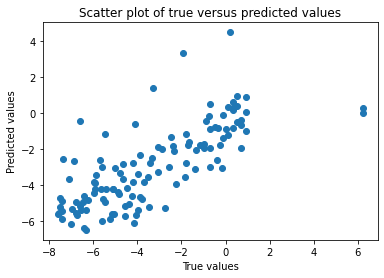

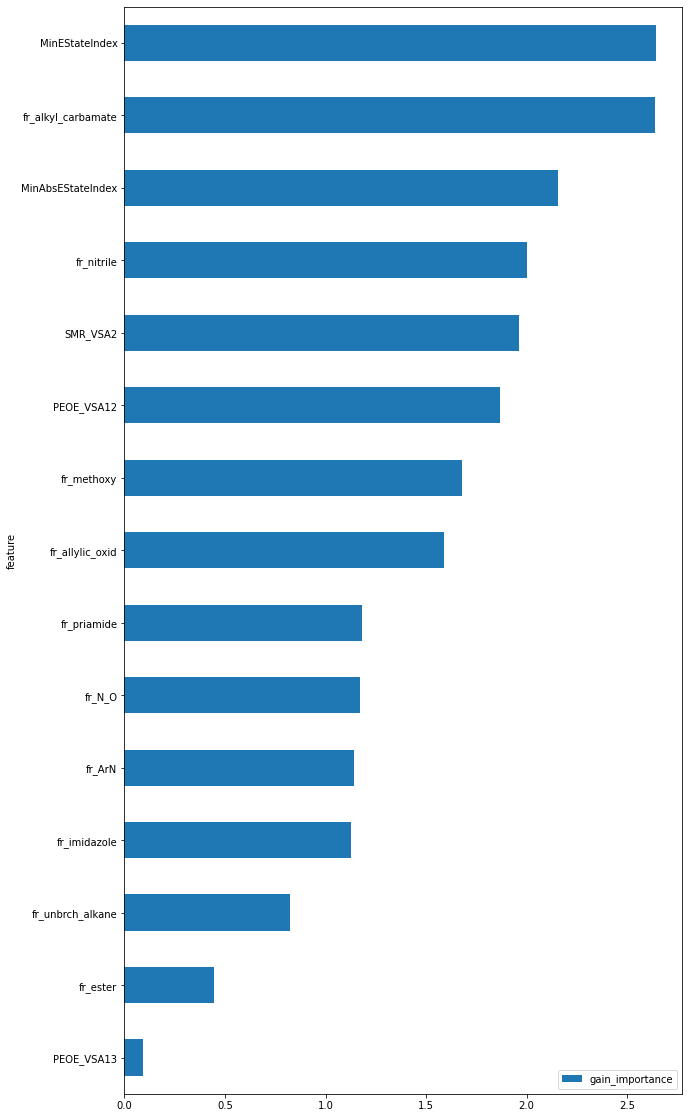

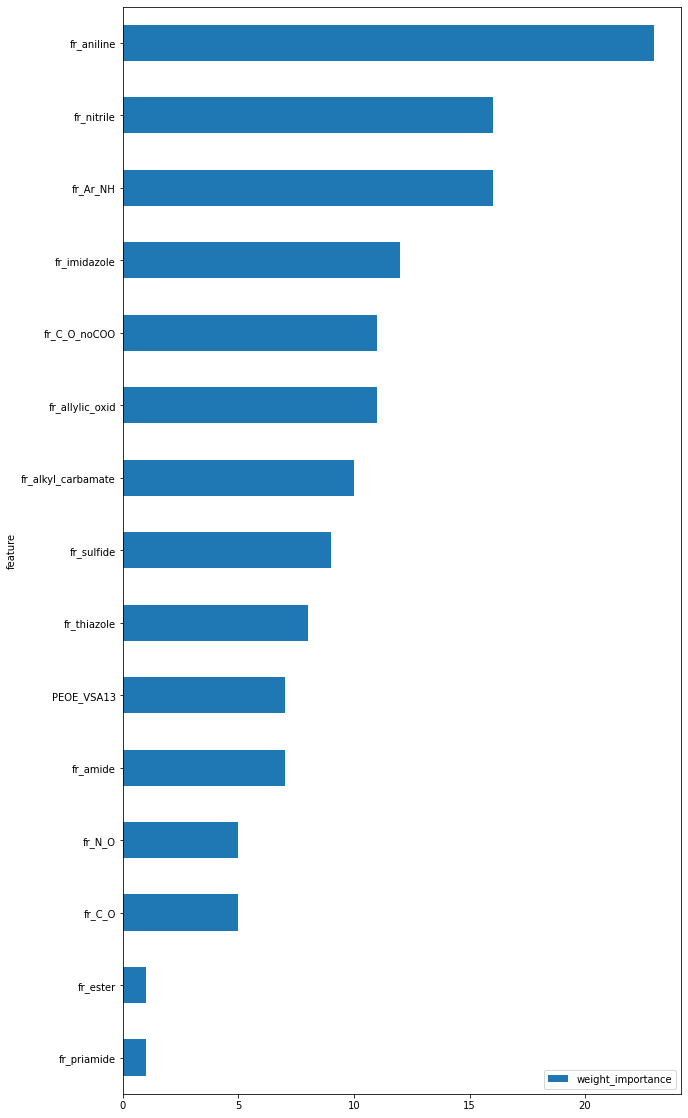

(               feature  gain_importance
 0       MaxEStateIndex         2.866073
 1       MinEStateIndex         2.642382
 2    MinAbsEStateIndex         2.155801
 3                  qed         2.872237
 4                MolWt         2.941727
 ..                 ...              ...
 152        fr_pyridine         6.303360
 153         fr_sulfide         2.958942
 154  fr_term_acetylene        11.149739
 155        fr_thiazole         4.221581
 156   fr_unbrch_alkane         0.821422
 
 [157 rows x 2 columns],
                feature  weight_importance
 0       MaxEStateIndex             7203.0
 1       MinEStateIndex             6296.0
 2    MinAbsEStateIndex             5603.0
 3                  qed             5235.0
 4                MolWt             4123.0
 ..                 ...                ...
 152        fr_pyridine               45.0
 153         fr_sulfide                9.0
 154  fr_term_acetylene              466.0
 155        fr_thiazole                8.0
 156   f

In [137]:
# xgb_trainer(df=df,
#             feature_col = FEATURES,
#             target_col=['pIC50'],
#            # test_index=df.query('group == "31678"').index
#            )

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 0.2, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(549, 167) (549, 1)
[0]	train-rmse:4.80510	valid-rmse:5.50183
[100]	train-rmse:4.41685	valid-rmse:5.22955
[200]	train-rmse:4.06495	valid-rmse:4.96973
[300]	train-rmse:3.74688	valid-rmse:4.74047
[400]	train-rmse:3.46020	valid-rmse:4.52840
[500]	train-rmse:3.20121	valid-rmse:4.35013
[600]	train-rmse:2.96704	valid-rmse:4.20086
[700]	train-rmse:2.75460	valid-rmse:4.05734
[800]	train-rmse:2.56324	valid-rmse:3.92606
[900]	train-rmse:2.39019	valid-rmse:3.81513
[1000]	train-rmse:2.23447	valid-rmse:3.71373
[1100]	train-rmse:2.09406	valid-rmse:3.62490
[1200]	train-rmse:1.96847	valid-rmse:3.54899
[1300]	train-rmse:1.85389	valid-rmse:3.47271
[1400]	train-rmse:1.75031	valid-rmse:3.40809
[1500]	train-rmse:1.65737	valid-rmse:3.34916
[1600]	train-rmse:1.57408	valid-rmse:3.

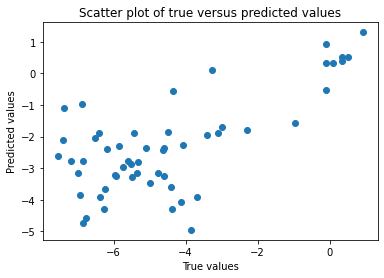

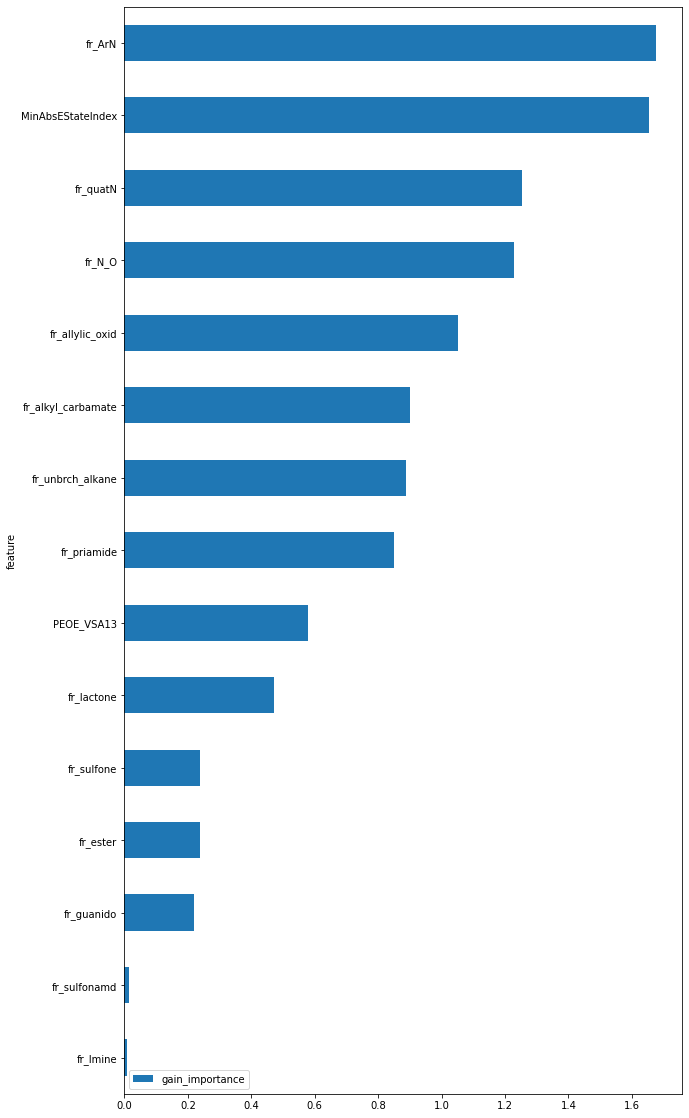

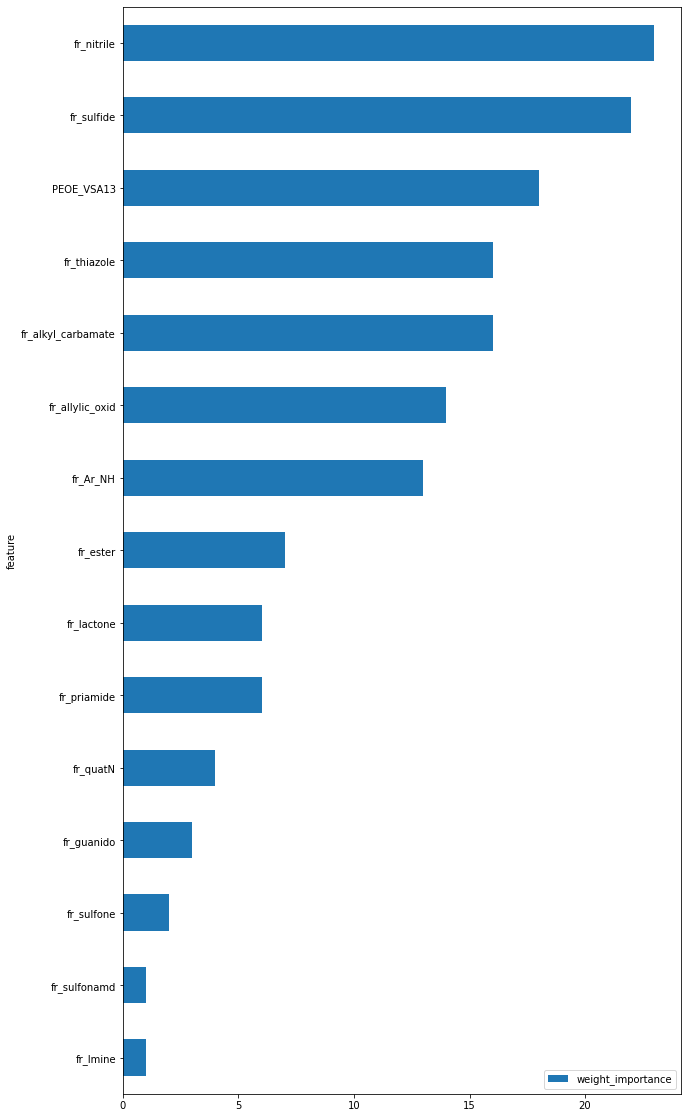

(               feature  gain_importance
 0       MaxEStateIndex         1.827591
 1       MinEStateIndex         1.707036
 2    MinAbsEStateIndex         1.654465
 3                  qed         1.719194
 4                MolWt         1.982520
 ..                 ...              ...
 158       fr_sulfonamd         0.014487
 159         fr_sulfone         0.238958
 160  fr_term_acetylene        10.831737
 161        fr_thiazole         5.097122
 162   fr_unbrch_alkane         0.888503
 
 [163 rows x 2 columns],
                feature  weight_importance
 0       MaxEStateIndex            10754.0
 1       MinEStateIndex             9578.0
 2    MinAbsEStateIndex             9389.0
 3                  qed             8462.0
 4                MolWt             6441.0
 ..                 ...                ...
 158       fr_sulfonamd                1.0
 159         fr_sulfone                2.0
 160  fr_term_acetylene              442.0
 161        fr_thiazole               16.0
 162   f

In [133]:
# xgb_trainer(df=df,
#             feature_col = FEATURES,
#             target_col=['pIC50'],
#            test_index=df.query('group == "31678"').index
#            )

xgb params is: {'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.8, 'colsample_bytree': 0.2, 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 123}
(511, 167) (511, 1)
[0]	train-rmse:4.14093	valid-rmse:3.80415
[100]	train-rmse:3.81960	valid-rmse:3.58585
[200]	train-rmse:3.52861	valid-rmse:3.38274
[300]	train-rmse:3.26601	valid-rmse:3.20999
[400]	train-rmse:3.02778	valid-rmse:3.06222
[500]	train-rmse:2.81249	valid-rmse:2.92815
[600]	train-rmse:2.61752	valid-rmse:2.81675
[700]	train-rmse:2.44012	valid-rmse:2.71871
[800]	train-rmse:2.28027	valid-rmse:2.63130
[900]	train-rmse:2.13588	valid-rmse:2.54861
[1000]	train-rmse:2.00642	valid-rmse:2.47932
[1100]	train-rmse:1.88906	valid-rmse:2.41565
[1200]	train-rmse:1.78328	valid-rmse:2.36572
[1300]	train-rmse:1.68683	valid-rmse:2.31764
[1400]	train-rmse:1.59933	valid-rmse:2.27862
[1500]	train-rmse:1.52083	valid-rmse:2.24269
[1600]	train-rmse:1.45022	valid-rmse:2.

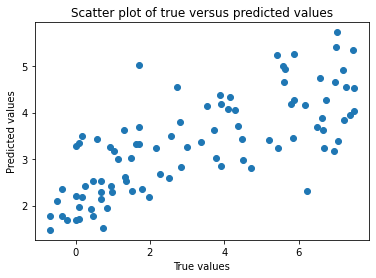

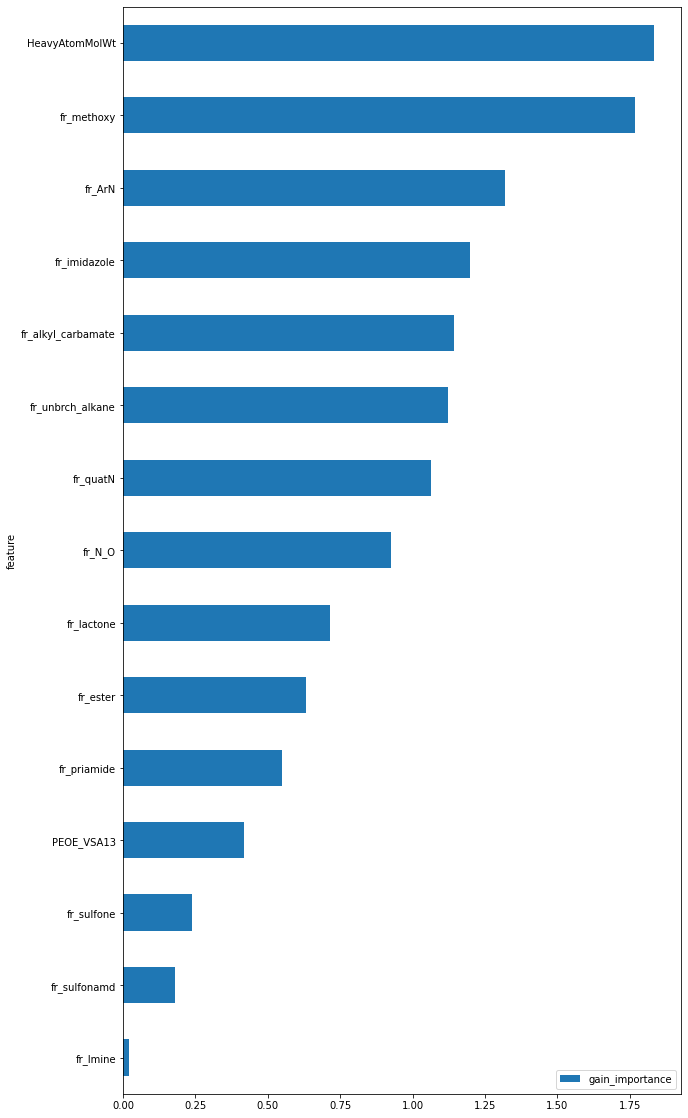

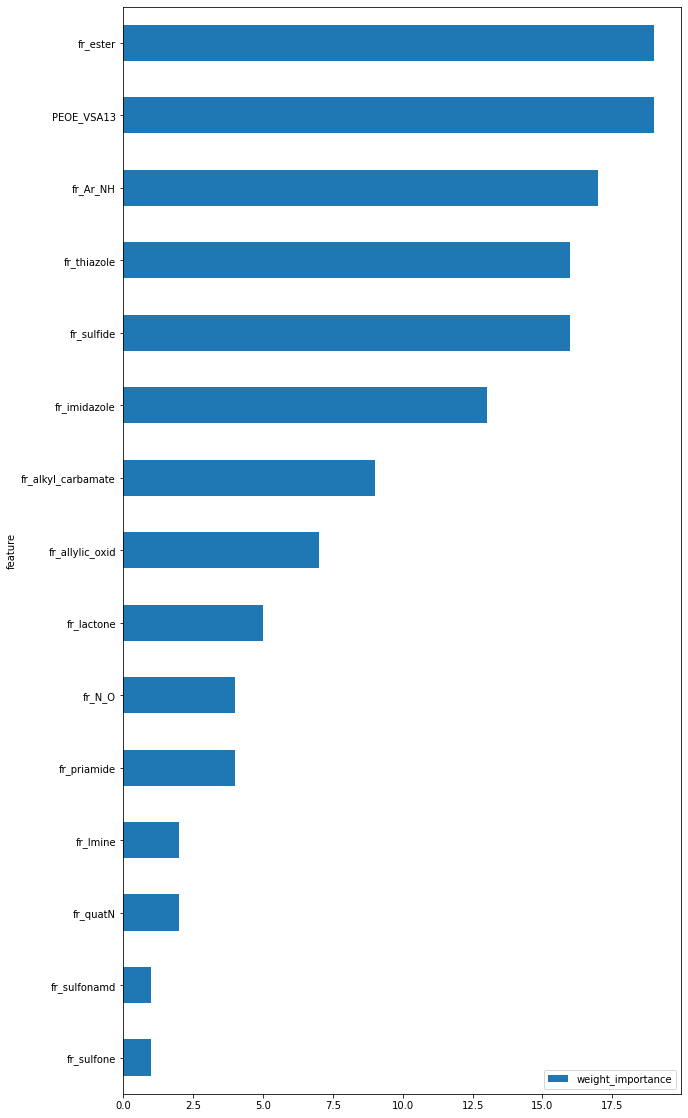

(               feature  gain_importance
 0       MaxEStateIndex         2.981783
 1       MinEStateIndex         1.853556
 2    MinAbsEStateIndex         1.961511
 3                  qed         2.239434
 4                MolWt         1.845078
 ..                 ...              ...
 157       fr_sulfonamd         0.179386
 158         fr_sulfone         0.238816
 159  fr_term_acetylene        12.849897
 160        fr_thiazole         3.286148
 161   fr_unbrch_alkane         1.123962
 
 [162 rows x 2 columns],
                feature  weight_importance
 0       MaxEStateIndex             9850.0
 1       MinEStateIndex             8266.0
 2    MinAbsEStateIndex             7962.0
 3                  qed             7411.0
 4                MolWt             5427.0
 ..                 ...                ...
 157       fr_sulfonamd                1.0
 158         fr_sulfone                1.0
 159  fr_term_acetylene              586.0
 160        fr_thiazole               16.0
 161   f

In [124]:
# xgb_trainer(df=df,
#             feature_col = FEATURES,
#             target_col=['IC50_log'],
#            test_index=df.query('group == "646"').index
#            )

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train_size = int(0.8 * train.shape[0])
# train_data = train.iloc[:train_size, :]
# test_data = train.iloc[train_size:, :]

# dtrain = xgb.DMatrix(train_data.drop('IC50', axis=1), label=train_data['IC50'])
# dvalid = xgb.DMatrix(test_data.drop('IC50', axis=1), label=test_data['IC50'])

# xgb_params = { 
#     'max_depth':7, #from 4 to 7
#     'learning_rate':0.001, #from 0.001
#     'subsample':0.8,
#     'colsample_bytree':1, # from 0.2 to 1, because need to take position
    
#     'eval_metric':'rmse',
#     'objective':'reg:squarederror',
#     'tree_method':'gpu_hist',
#     'predictor':'gpu_predictor',
#     'random_state':123
# }

# model = xgb.train(xgb_params, 
#             dtrain=dtrain,
#             evals=[(dtrain,'train'),(dvalid,'valid')],
#             num_boost_round=9999,
#             early_stopping_rounds=100,
#             verbose_eval=100,)

# test_data['pred'] = model.predict(dvalid)

# spearman_corr, _ = spearmanr(test_data['IC50'], test_data['pred'])

# print(f'Spearman correlation: {spearman_corr:.2f}')

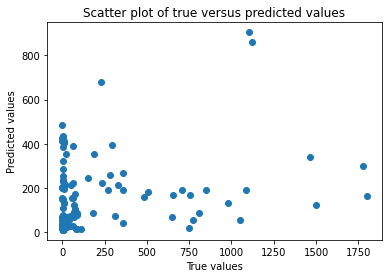

In [133]:
# fig, ax = plt.subplots()
# ax.scatter(test_data['IC50'], test_data['pred'])
# ax.set_xlabel('True values')
# ax.set_ylabel('Predicted values')
# ax.set_title('Scatter plot of true versus predicted values')
# plt.show()

In [135]:
# dd = model.get_score(importance_type='gain')
# gain = pd.DataFrame({'feature':dd.keys(),f'importance':dd.values()})


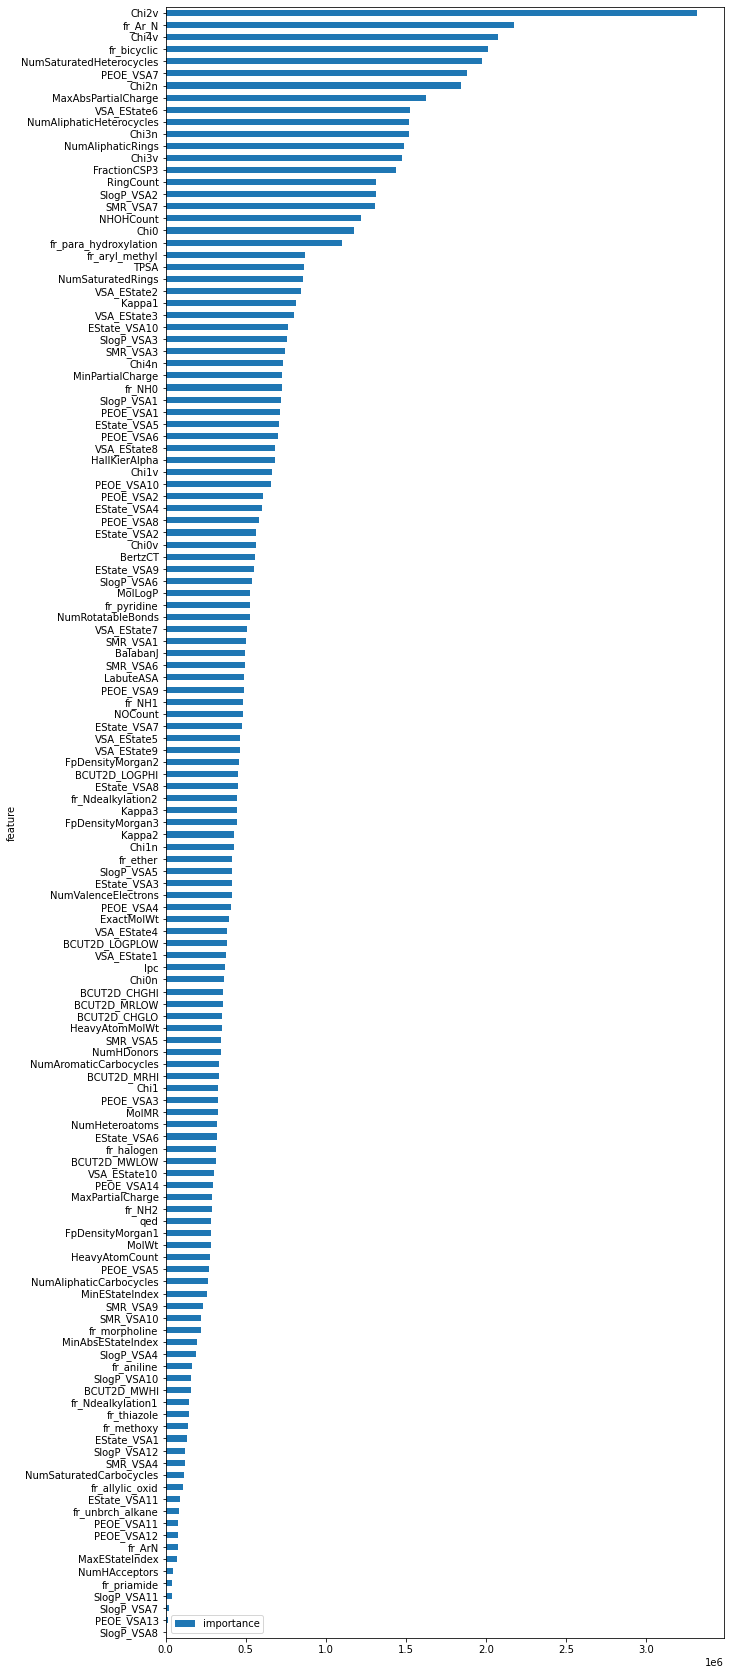

In [146]:
# gain.set_index('feature').sort_values(by = 'importance').plot.barh(figsize=(10,30));

Concatenate features, prepare training

In [41]:
# smi_feat

,ID,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ester,fr_ether,fr_guanido,fr_halogen,fr_imidazole,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_para_hydroxylation,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_unbrch_alkane,fr_urea
0,US_1,-1.932028,0.932171,1.381110,0.495241,-1.183587,-1.219109,-1.182076,-1.046640,-0.203173,-1.070885,0.960805,-0.201299,-0.606818,-0.027786,0.238330,-0.929849,0.169612,-1.291745,0.519884,-1.519547,0.185658,-0.425142,0.608875,0.337035,-0.603426,-1.036679,-0.801448,-0.917005,-0.932184,-0.777188,-0.867430,-0.807099,-0.902348,-0.806015,-0.900582,-0.864011,-0.972370,-0.126939,-0.154995,-1.075533,-0.754664,-0.327962,-0.976340,0.813537,-1.109378,-1.722754,-0.237511,-0.150438,-0.258243,-0.690788,-1.677478,-0.252705,-0.275917,-0.455194,0.586341,-0.695775,0.424056,-0.818465,-0.302768,-0.193272,0.123156,-0.361079,-0.742411,-0.199686,-0.279138,0.655344,-0.36044,-1.709988,0.908283,-0.727266,0.045041,-0.772241,-1.454431,-0.791409,0.740918,-0.673271,0.606634,0.257682,-1.120582,-0.123426,-1.959448,-1.622800,-1.137956,0.581413,0.436907,-0.082673,0.600444,-0.316618,0.410895,-1.477411,-0.713491,-0.020944,0.966588,0.316115,0.706608,1.074237,0.035838,-0.307140,0.688654,-0.495195,-0.975006,0.504157,0.034921,-0.393,-0.446513,-0.613431,0.241193,0.123187,0.298974,0.164340,0.642889,-1.190554,-0.645101,-0.356435,-0.308046,-0.465984,-0.535647,-0.875193,-0.643206,-0.037242,-0.289541,-0.278433,-0.145659,-0.016211,-0.164399,1.260085,-0.052705,-0.321026,-0.31841,-0.087167,-0.037242,-0.098784,-0.261324,-0.215353,-0.051678,1.432247,1.722508,-0.091542,-0.14062,-0.508104,-0.070507,-0.309352,-0.493979,-0.51257,-0.342359,-0.052705,-0.316228,-0.052705,-1.583939,-0.204565,-0.037242,-0.258067,-0.145659,-0.185429,-0.211808,-0.183176,0.327661,-0.052705,0.357590,-0.037242,-0.083507,-0.037242,-0.052705,-0.204565,-0.091542,-0.16413,-0.037242
1,US_2,0.370290,0.282627,-0.324387,0.318811,-0.840874,-0.837744,-0.838700,-0.740120,-0.200922,-1.070885,0.960805,-0.198749,0.203344,0.332533,0.322539,-0.646890,0.160857,-1.217596,0.513626,-0.927388,0.182332,-0.416530,0.608299,0.705937,-0.323952,-0.697765,-0.663958,-0.781950,-0.685520,-0.697979,-0.791224,-0.730912,-0.830814,-0.734399,-0.831915,-0.806103,-0.915471,-0.260409,-0.153546,-0.753847,-0.57500

In [36]:
# # if the sample size is too small, can't use pca to reduce dimension
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2,random_state = 123)

# seq_pca = pca.fit_transform(seq_feat.values)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()